In [1]:
# 1. Import all the required libraries.

%matplotlib inline
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image
import pathlib
import csv 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras import layers
from keras import layers
import keras
from keras.models import Sequential

In [2]:
# 2. Extract and load your data
file_path = 'C:\\emotion data\\emotional speech data'
output_path = 'C:\\emotion data\\images'

In [3]:
# 3. Now convert the audio data files into PNG format images or basically extracting the Spectrogram for every Audio.

cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
emotion = 'OAF_angry OAF_disgust OAF_Fear OAF_happy OAF_neutral OAF_Pleasant_surprise OAF_Sad'.split()

for g in emotion:
    pathlib.Path(f'{file_path}/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'{file_path}/{g}'):
        emotionname = f'{file_path}/{g}/{filename}'
        y, sr = librosa.load(emotionname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'{output_path}/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf();

<Figure size 800x800 with 0 Axes>

In [4]:
# Now since all the audio files got converted into their respective spectrograms it’s easier to extract features.

# 4. Creating a header for our CSV file.

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [5]:
#  Extracting features from Spectrogram: We will extract Mel-frequency cepstral coefficients (MFCC), 
#  Spectral Centroid, Zero Crossing Rate, Chroma Frequencies, and Spectral Roll-off.

csv_path = "C:\\emotion data\\"
file = open(f'{csv_path}/dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'OAF_angry OAF_disgust OAF_Fear OAF_happy OAF_neutral OAF_Pleasant_surprise OAF_Sad'.split()
for g in genres:
    for filename in os.listdir(f'{file_path}/{g}'):
        songname = f'{file_path}/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        rmse = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open(f'{csv_path}/dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())


In [6]:
# 6. Data preprocessing: It involves loading CSV data, label encoding, feature scaling 
#     and data split into training and test set.

data = pd.read_csv(f'{csv_path}/dataset.csv')
data.head()# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# 7. Building an ANN model.

model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# 8. Fit the model

from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10)

classifier = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping_callback])

Epoch 1/100
9/9 [==============================] - 0s 11ms/step - loss: 9.3507e-05 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.9929
Epoch 2/100
9/9 [==============================] - 0s 8ms/step - loss: 9.1124e-05 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.9929
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 8.9313e-05 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.9929
Epoch 4/100
9/9 [==============================] - 0s 8ms/step - loss: 8.7593e-05 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.9929
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 8.5825e-05 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 0.9929
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 8.4288e-05 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.9929
Epoch 7/100
9/9 [==============================] - 0s 8ms/step - loss: 8.2673e-05 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.992

9/9 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9929
Accuracy of our model on test data :  99.28571581840515 %


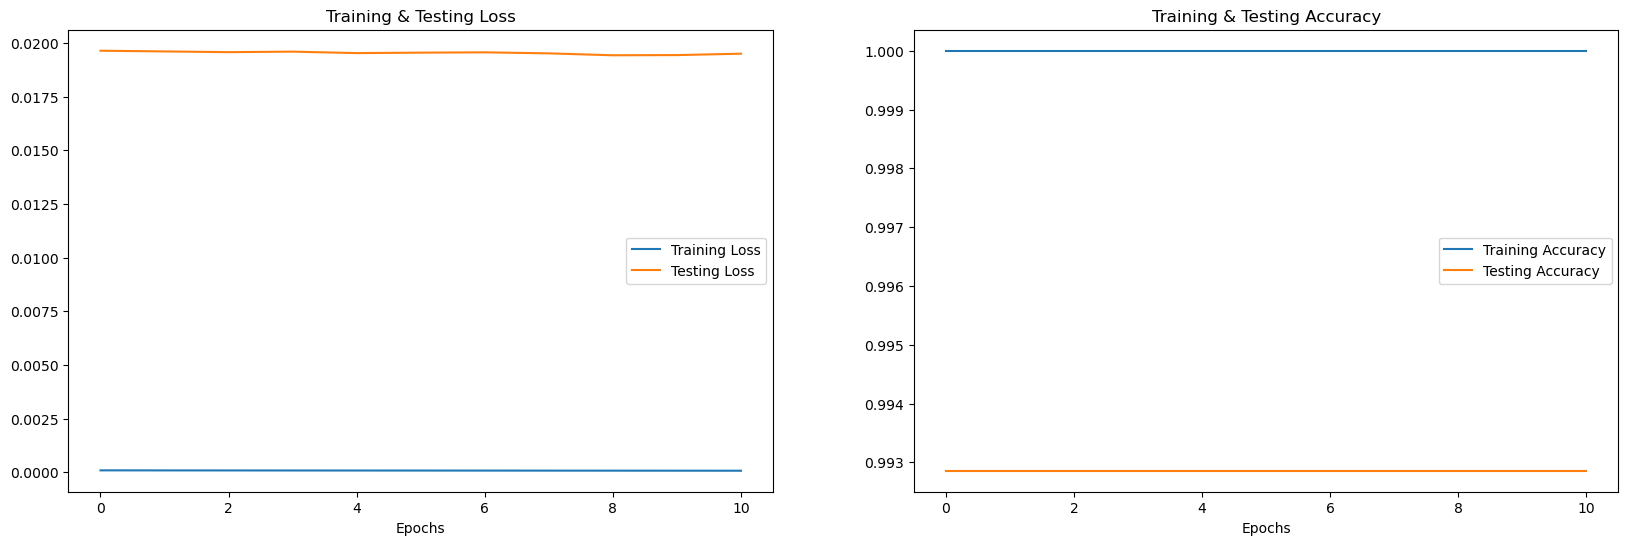

In [16]:
print("Accuracy of our model on test data : " , model.evaluate(X_test, y_test)[1]*100 , "%")

epochs = classifier.epoch
fig , ax = plt.subplots(1,2)
train_acc = classifier.history['accuracy']
train_loss = classifier.history['loss']
test_acc = classifier.history['val_accuracy']
test_loss = classifier.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [35]:
pred_test = model.predict(X_test)
y_pred = np.argmax(pred_test, axis=1)

y_test_label = encoder.inverse_transform(y_test)

9/9 [==============================] - 0s 2ms/step


In [41]:
y_pred_label = encoder.inverse_transform(y_pred)

In [43]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_label.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,OAF_disgust,OAF_disgust
1,OAF_neutral,OAF_neutral
2,OAF_angry,OAF_angry
3,OAF_happy,OAF_happy
4,OAF_happy,OAF_happy
5,OAF_disgust,OAF_disgust
6,OAF_neutral,OAF_neutral
7,OAF_Pleasant_surprise,OAF_Pleasant_surprise
8,OAF_disgust,OAF_disgust
9,OAF_happy,OAF_happy


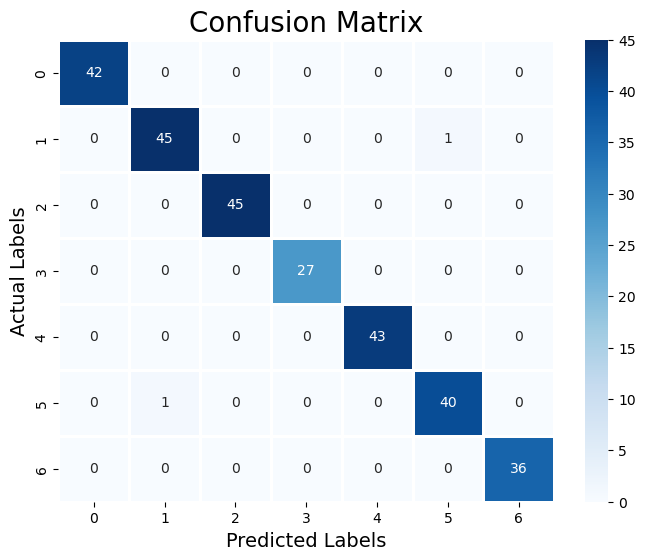

In [49]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize = (8, 6))
# cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [51]:
print(classification_report(y_test, y_pred_label))

                       precision    recall  f1-score   support

             OAF_Fear       1.00      1.00      1.00        42
OAF_Pleasant_surprise       0.98      0.98      0.98        46
              OAF_Sad       1.00      1.00      1.00        45
            OAF_angry       1.00      1.00      1.00        27
          OAF_disgust       1.00      1.00      1.00        43
            OAF_happy       0.98      0.98      0.98        41
          OAF_neutral       1.00      1.00      1.00        36

             accuracy                           0.99       280
            macro avg       0.99      0.99      0.99       280
         weighted avg       0.99      0.99      0.99       280

